In [1]:
### Preamble
# Math and data processing
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.stats import sigma_clip
from astropy.time import Time
from math import sqrt, pi
from scipy.io import readsav
from importlib import reload
# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
# Self-defined
import ML_util as util
import plot_util as p_util
import keck_data_compiler as comp

In [2]:
# Data directories
data_dir = "data/"
ao_root = 'ao_telemetry/'
steve_file = data_dir+"lgs_metadata.fits"
NAN_YEAR = 1858.876712328767

In [3]:
### Read in Steve's data
file = Table.read(steve_file, format='fits')
steve_data = file.to_pandas()
steve_data.describe()

strehl      rms_err         fwhm           mjd      airmass  \
count  5949.000000  5949.000000  5949.000000   5949.000000  5949.000000   
mean      0.281083   383.117079    67.839193  56117.752875     1.583200   
std       0.100528    51.807862    19.021460   1305.547327     0.094087   
min      -1.000000    -1.000000    -1.000000  53212.346420     1.515730   
25%       0.233000   350.100000    58.330000  55036.327970     1.524350   
50%       0.292000   374.700000    63.630000  56132.355430     1.551410   
75%       0.342000   407.600000    72.150000  57243.317310     1.605690   
max       0.615000   722.900000   442.630000  57991.296820     2.268440   

             itime       coadds           az       dmgain       dtgain  ...  \
count  5949.000000  5949.000000  5949.000000  5949.000000  5949.000000  ...   
mean      2.805354    10.339385   177.907009     0.297084     0.104504  ...   
std       0.344479     5.939079    15.797041     0.078659     0.089278  ...   
min       0.181000     3.000000   138.497840     0.200000     0.010000  ...   
25%       2.800000    10.000000   165.695560     0.250000     0.050000  ...   
50%       2.800000    10.000000   179.373300     0.250000     0.075000  ...   
75%       2.800000    10.000000   191.085560     0.350000     0.100000  ...   
max       8.000000   120.000000   204.037230     0.600000     0.500000  ...   

       MASSPRO_delta_t  wind_speed[kts]   wind_speed  wind_direction  \
count      3281.000000      5949.000000  5949.000000     5949.000000   
mean         -0.225573        11.676542     6.006932     -221.363591   
std           0.480427         8.482568     4.363810     1830.418981   
min          -1.781127         0.000000     0.000000   -10000.000000   
25%          -0.006460         5.220000     2.685400       65.000000   
50%          -0.000206        11.000000     5.658889       94.000000   
75%           0.000267        16.520000     8.498622      137.000000   
max           0.102330        36.520000    18.787511      355.000000   

       temperature  relative_humidity  pressure[mb]     pressure  \
count  5949.000000         5949.00000   5949.000000  5949.000000   
mean      2.357018           23.33720    618.047067     0.618047   
std       1.988321           18.10659      2.042654     0.002043   
min      -3.290000            2.00000    611.900000     0.611900   
25%       1.040000           10.00000    616.700000     0.616700   
50%       2.450000           16.00000    618.300000     0.618300   
75%       3.730000           34.00000    619.600000     0.619600   
max       6.880000           80.00000    622.400000     0.622400   

           cfht_mjd  cfht_delta_t  
count   5949.000000   5949.000000  
mean   56117.748694      0.004181  
std     1305.544130      0.066346  
min    53212.347222     -0.001988  
25%    55036.329167     -0.000220  
50%    56132.355556      0.000007  
75%    57243.317361      0.000226  
max    57991.296528      1.204238  

[8 rows x 42 columns]

In [4]:
### Uncomment if you want to reload the metadata file
# comp.update()

In [5]:
### Read in my own data
#reload(util)
my_data = pd.read_csv(data_dir+"keck_metadata.dat")
my_data = util.clean(my_data)
my_data.columns = [x.lower() for x in my_data.columns]
# Add decimal year
year = Time(my_data.mjd, format='mjd').decimalyear
my_data['dec_year'] = year
my_data.describe()

strehl      rms_err         fwhm           mjd      airmass  \
count  5609.000000  5609.000000  5609.000000   5609.000000  5609.000000   
mean      0.284743   383.565431    68.229344  56188.937373     1.584688   
std       0.081482    49.053077    18.319587   1301.087299     0.096151   
min       0.010000   235.900000    49.180000  53551.388640     1.515730   
25%       0.233000   349.400000    58.570000  55320.538430     1.524420   
50%       0.294000   374.000000    63.850000  56408.598650     1.551930   
75%       0.343000   407.600000    72.390000  57244.288680     1.606960   
max       0.615000   722.900000   442.630000  57991.296820     2.268440   

             itime       coadds           az       dmgain       dtgain  ...  \
count  5609.000000  5609.000000  5609.000000  5609.000000  5609.000000  ...   
mean      2.810347    10.288643   177.605860     0.293965     0.101827  ...   
std       0.336976     5.881917    15.896917     0.074047     0.085646  ...   
min       0.181000     3.000000   138.497840     0.200000     0.010000  ...   
25%       2.800000    10.000000   165.204910     0.250000     0.050000  ...   
50%       2.800000    10.000000   179.086180     0.250000     0.075000  ...   
75%       2.800000    10.000000   190.904720     0.350000     0.100000  ...   
max       8.000000   120.000000   204.037230     0.600000     0.500000  ...   

          masspro_4     masspro_8    masspro_16      masspro   wind_speed  \
count  2.959000e+03  2.959000e+03  2.959000e+03  2959.000000  5609.000000   
mean   2.668078e-14  3.439663e-14  1.578247e-14     0.276512    12.194072   
std    4.563597e-14  5.068500e-14  1.401443e-14     0.167567     8.360304   
min    1.300000e-23  4.100000e-25  2.100000e-24     0.060000     0.000000   
25%    2.450000e-15  2.110000e-15  8.980000e-15     0.170000     6.960000   
50%    1.210000e-14  1.560000e-14  1.300000e-14     0.230000    11.300000   
75%    2.960000e-14  4.705000e-14  1.760000e-14     0.330000    17.000000   
max    4.660000e-13  3.350000e-13  1.550000e-13     1.420000    36.520000   

       wind_direction  temperature  relative_humidity     pressure  \
count     5609.000000  5609.000000        5609.000000  5609.000000   
mean       117.707791     2.359317          21.345338   618.070957   
std         76.287349     1.999279          15.208372     2.050005   
min          0.000000    -3.290000           2.000000   611.900000   
25%         67.000000     1.060000          10.000000   616.700000   
50%         97.000000     2.560000          15.000000   618.200000   
75%        136.000000     3.740000          30.000000   619.600000   
max        353.000000     6.880000          79.000000   622.400000   

          dec_year  
count  5609.000000  
mean   2012.716029  
std       3.562081  
min    2005.494215  
25%    2010.338461  
50%    2013.316709  
75%    2015.606270  
max    2017.650128  

[8 rows x 39 columns]

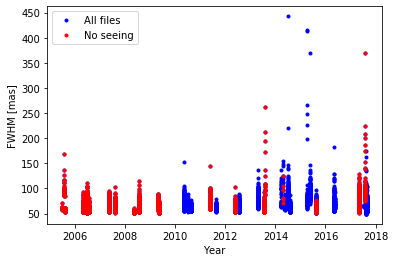

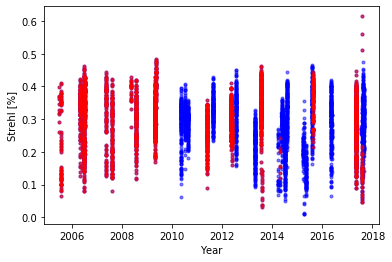

In [6]:
### Methods section figure: Data Sets
### Which NIRC2 observations have weather, seeing, and telemetry data
data = my_data

# Find NaN values
no_seeing = data[np.isnan(data.mass_mjd)]

# Find decimal year
all_dates = Time(data.mjd, format='mjd').decimalyear
no_seeing_dates = Time(no_seeing.mjd, format='mjd').decimalyear

plt.plot(all_dates, data.fwhm, 'b.', label="All files")

plt.plot(no_seeing_dates, no_seeing.fwhm, 'r.', label="No seeing")
plt.legend()

plt.xlabel("Year")
plt.ylabel("FWHM [mas]")
plt.savefig(p_util.plot_dir+"Observations/"+"FWHM_data.png", bbox_inches='tight')
plt.show()

plt.plot(all_dates, data.strehl, 'b.', alpha=0.5)
plt.plot(no_seeing_dates, no_seeing.strehl, 'r.', alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Strehl [%]")
plt.savefig(p_util.plot_dir+"Observations/"+"strehl_data.png", bbox_inches='tight')
plt.show()

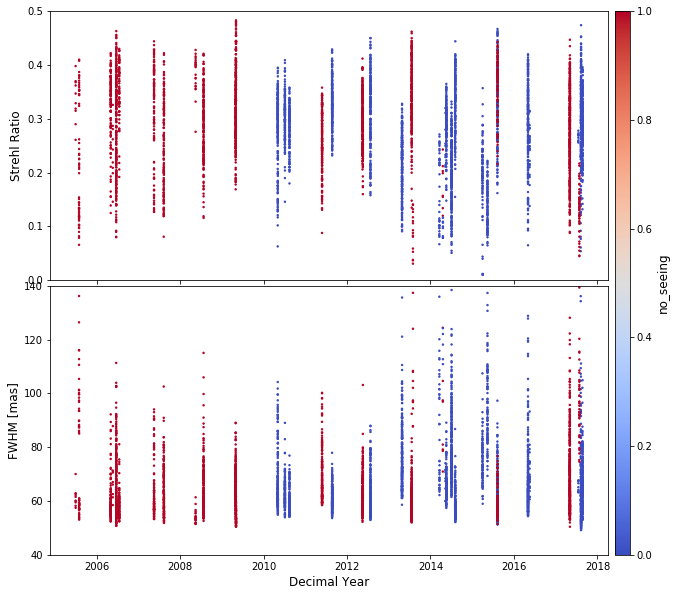

In [7]:
data = my_data
no_seeing = np.isnan(data.mass_mjd)
cols = ['strehl', 'fwhm', 'dec_year']
data = my_data[cols].copy()
data['no_seeing'] = no_seeing

p_util.plot_vars(data, x_vars=['dec_year'], y_vars=['strehl', 'fwhm'], c_var='no_seeing', 
                 cmap='coolwarm', figsize=(10,10))

### Methods: Weather Analysis

In [8]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/plot_util.py'>

##### Data-on-data weather & seeing plots

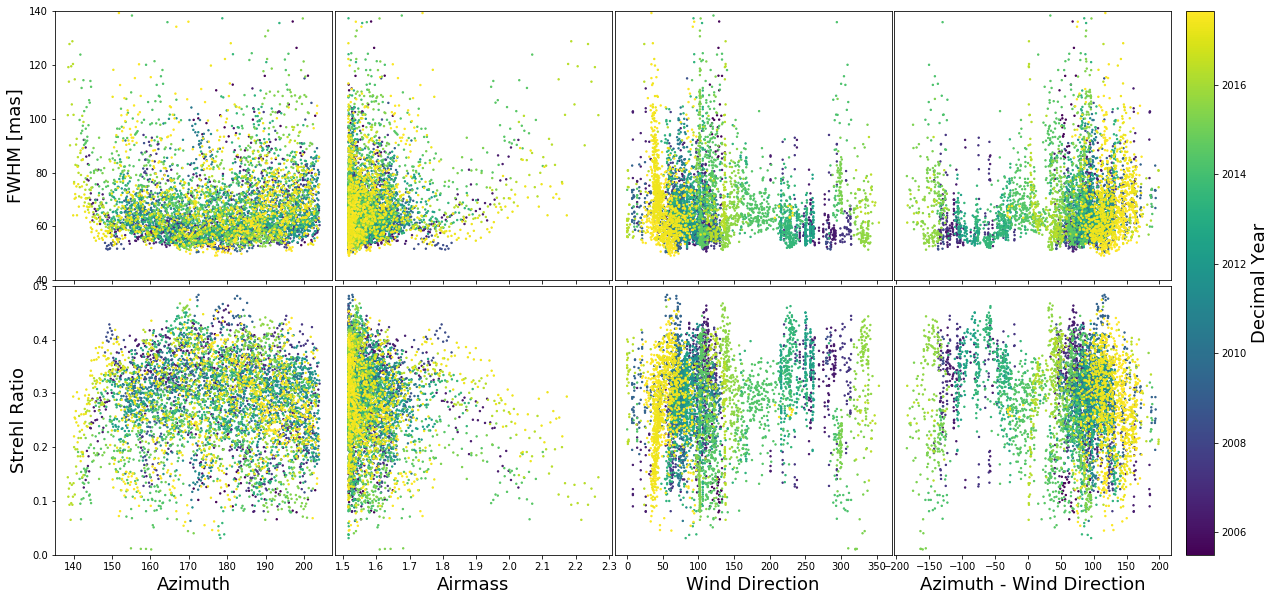

In [9]:
### First data-on-data plot:
### Azimuth, Airmass, Wind Direction, Azimuth - Wind Direction vs. image quality
data = my_data
p_util.setup("Methods", "weather")

# Save settings
settings = p_util.default_settings.copy()
settings['label'].update({'az-wdir':'Azimuth - Wind Direction'})
data['az-wdir'] = data['az']-data['wind_direction']
# Plot
x_vars = ['az', 'airmass', 'wind_direction', 'az-wdir']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=18, settings=settings, save=True)

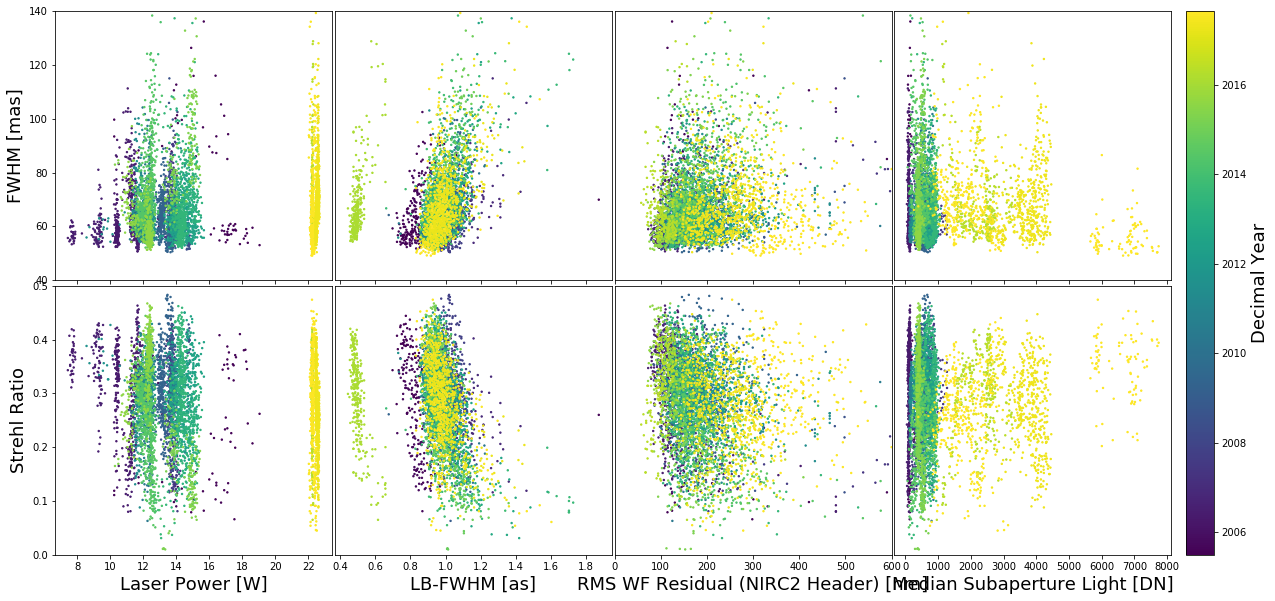

In [10]:
### Second data-on-data plot:
### AOAOMED, LSAMPPWR, AOLBFWHM, LGRMSWF vs. strehl and fwhm
data = my_data
p_util.setup("Methods", 'weather')

x_vars = ['lsamppwr', 'aolbfwhm', 'lgrmswf', 'aoaoamed']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=18, save=True)

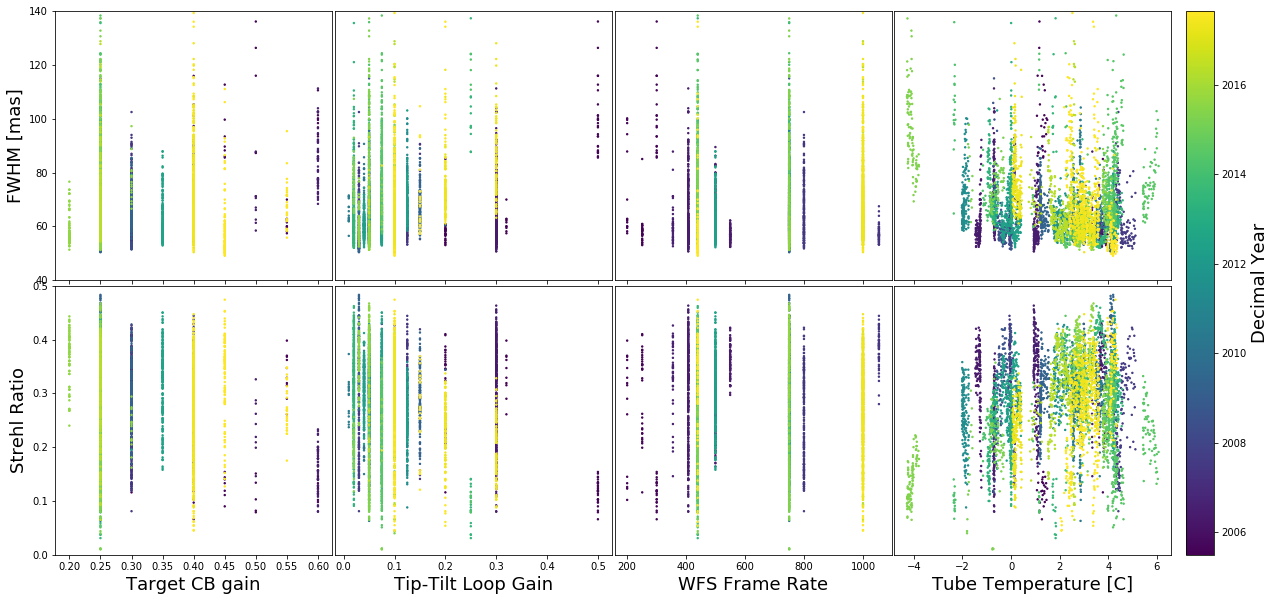

In [11]:
### Third data-on-data plot:
### tubetemp, dmgain, dtgain, and wsfrrt
data = my_data
p_util.setup("Methods", 'weather')

# Save settings
# settings = p_util.default_settings.copy()
# settings['label'].update({'ttemp-temp':'Tube temp. - Temp [C]'})
# data['ttemp-temp'] = data['tubetemp']-data['temperature']
# Plot
x_vars = ['dmgain', 'dtgain', 'wsfrrt', 'tubetemp']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=18, settings=settings, save=True)

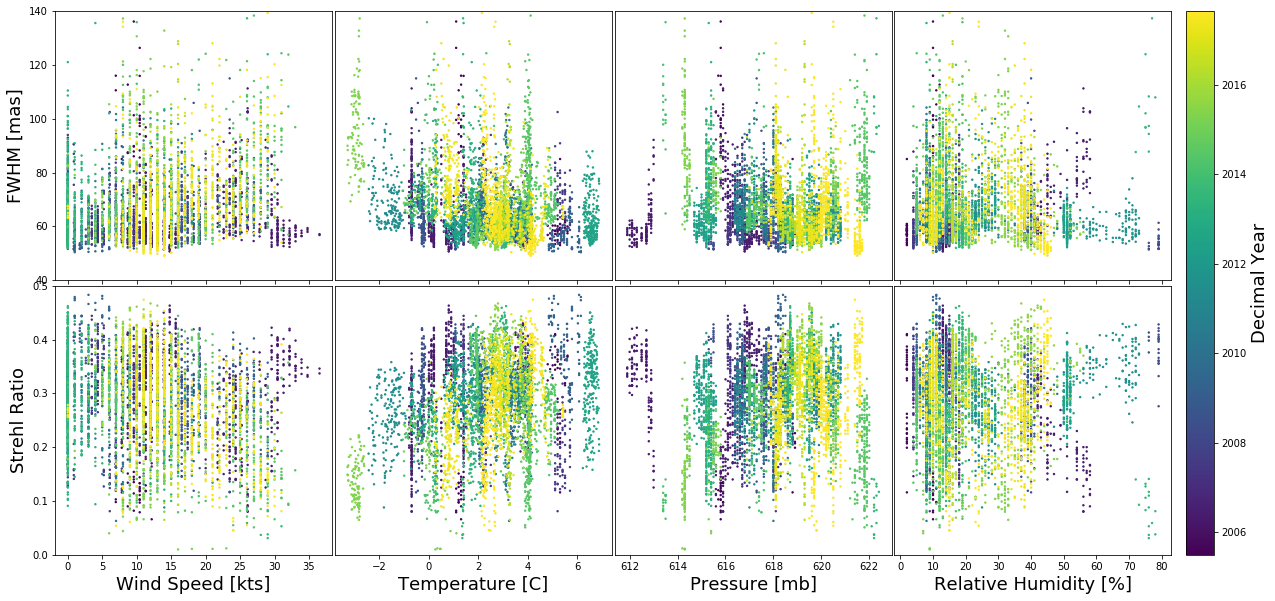

In [12]:
### Fourth data-on-data plot
### wind_speed, temperature, pressure, and relative_humidity
data = my_data
p_util.setup("Methods", 'weather')

x_vars = ['wind_speed', 'temperature', 'pressure', 'relative_humidity']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=18, save=True)

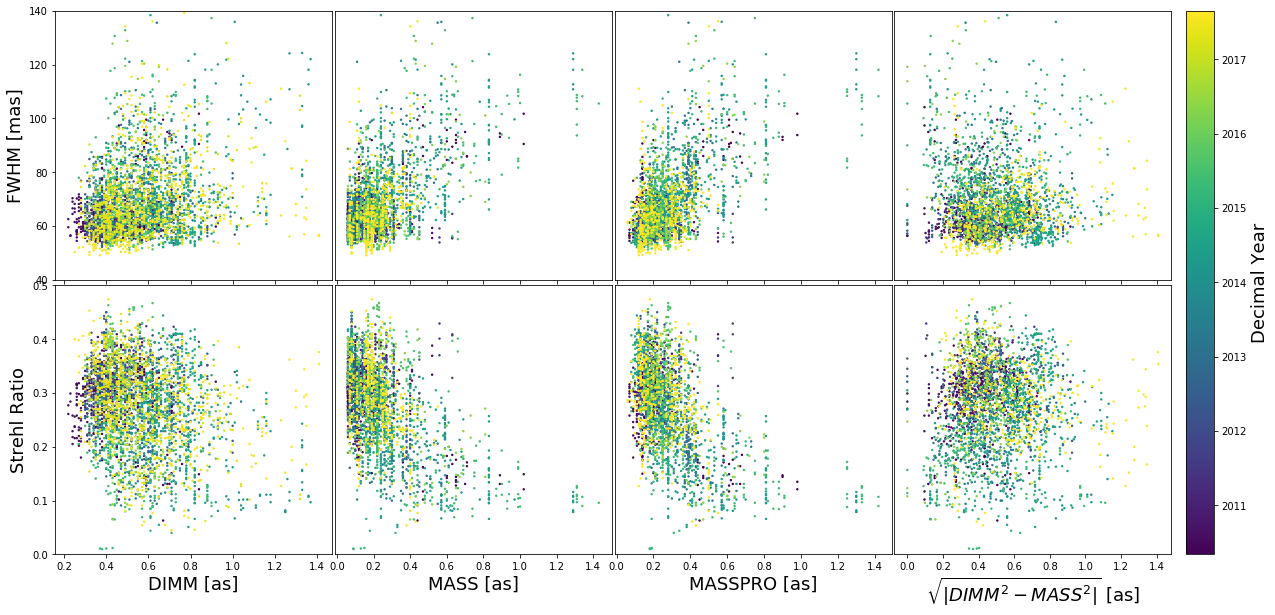

In [13]:
### Fifth data-on-data plot:
### Seeing variables
data = my_data
p_util.setup("Methods", 'weather')

# Save settings
settings = p_util.default_settings.copy()
settings['label'].update({'sqrt-d2-m2':'$\sqrt{|DIMM^2-MASS^2|}$ [as]'})
data['sqrt-d2-m2'] = np.sqrt(np.abs(data.dimm**2 - data.mass**2))
# Plots
x_vars = ['dimm', 'mass', 'masspro', 'sqrt-d2-m2']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', settings=settings, fontsize=18, save=True)

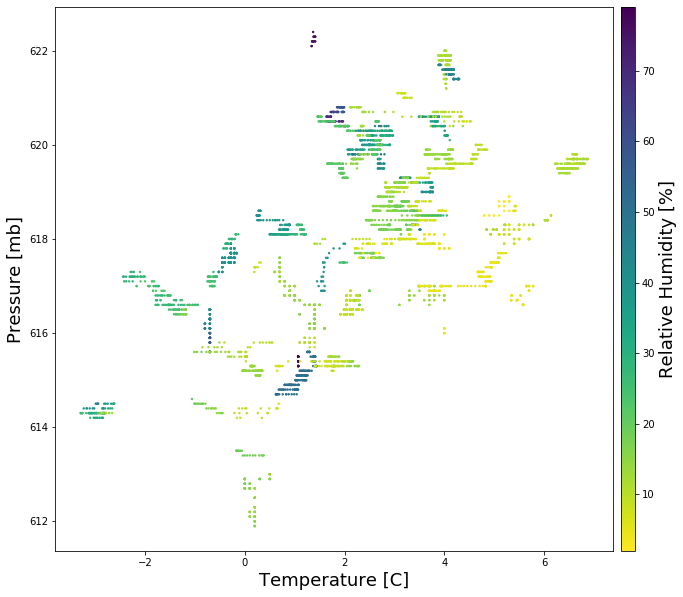

In [14]:
### Sixth data-on-data plot:
### Pressure-v-Temperature
data = my_data
p_util.setup("Methods", 'weather')

x_vars = ['temperature']
y_vars = ['pressure']
p_util.plot_vars(data, x_vars, y_vars, c_var='relative_humidity', fontsize=18, figsize=(10, 10), 
                 cmap='viridis_r', save=True)

### Methods: Telemetry Analysis

In [15]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/plot_util.py'>

In [16]:
# Read in test file
testfile1 = "/g/lu/data/keck_telemetry/20170718/sdata901/nirc15/2017jul18/n0098_LGS_trs.sav"
testfile2 = "/g/lu/data/keck_telemetry/20150402/sdata903/nirc9/2015apr02_B/n0001_fullNGS_trs.sav"

##### Offset Centroids vs. time

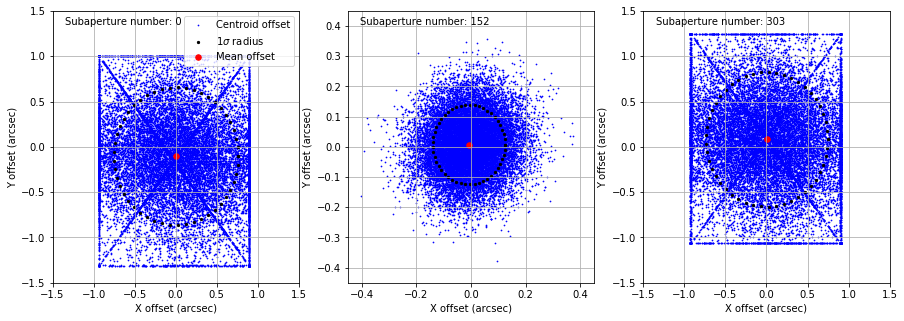

In [17]:
### Plot offset-centroids for three lenslets
p_util.setup("Methods", 'telemetry')
p_util.plot_lenslets(testfile1, [0, 152, 303], shape=(1,3), xlim={152:(-.45,.45)}, save=True)

# Results Section

##### Plot lenslet arrays

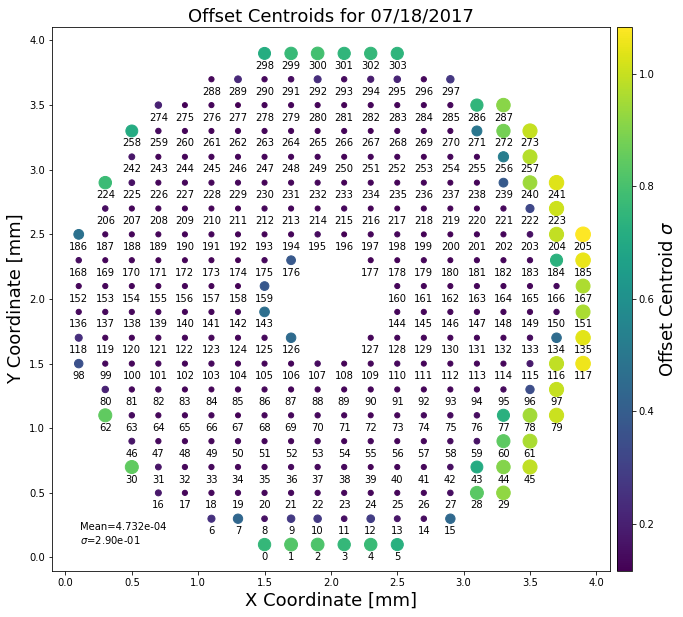

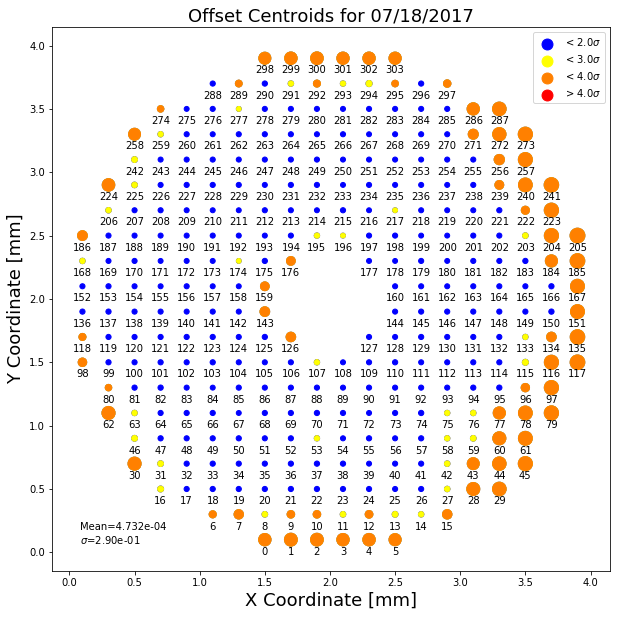

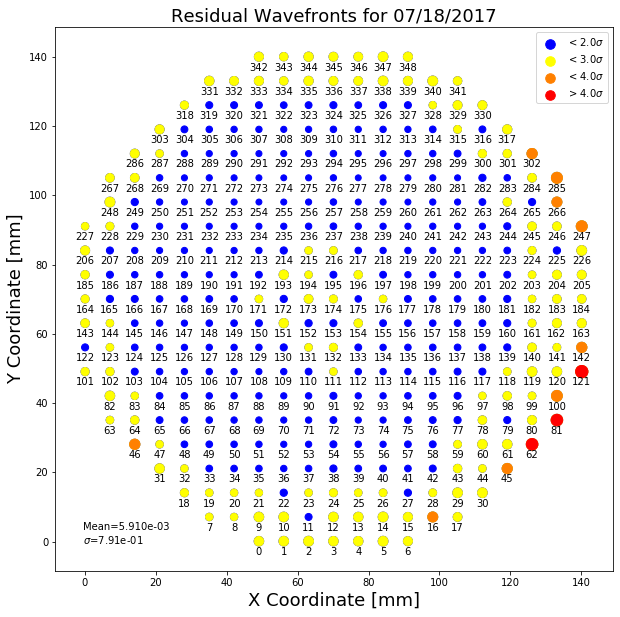

In [18]:
### Three lenslet arrays
p_util.setup("Results", 'telemetry')
save = True

file = testfile1
p_util.plot_array(file, save=save)
p_util.plot_array(file, sig_clip=[2.0, 3.0, 4.0], save=save)
p_util.plot_array(file, data_type='residual wavefront', sig_clip=[2.0, 3.0, 4.0], 
                  map_file='ao_telemetry/act.txt', save=save)

#### Telemetry Correlations

In [19]:
### Read in data
tel_file = "ao_telemetry/telemetry_table.fits"
meta_file = "ao_telemetry/metadata_table.fits"
df_tele = Table.read(tel_file, format='fits').to_pandas()
df_meta = Table.read(meta_file, format = 'fits').to_pandas()

In [20]:
### Consolidate data
df3 = pd.DataFrame()
df3['rms_err'] = df_meta['rms_err']
df3['lgrmswf'] = df_meta['lgrmswf']
df3['residual_rms'] = df_tele['residual_rms']
df3['residual_rms_std'] = df_tele['residual_rms_std']

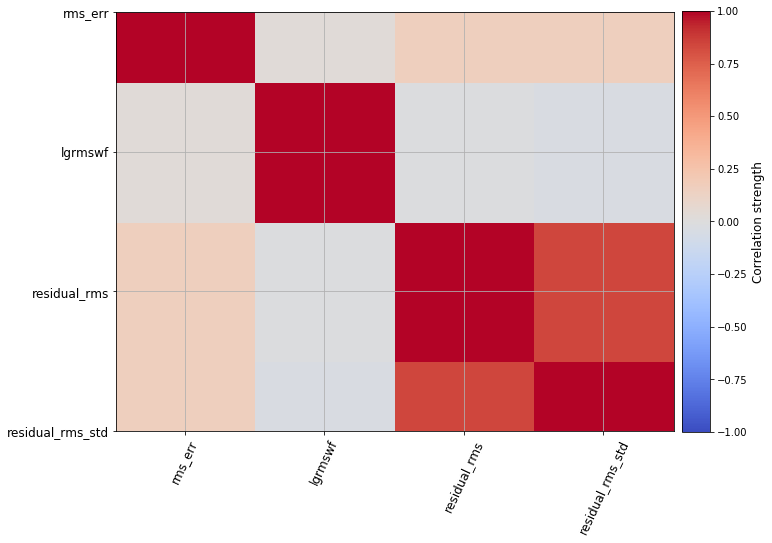

In [21]:
### Correlation matrix
p_util.setup("Results", 'combined')
p_util.correlation_matrix(df3, cax=[.91, .21, 0.04, 0.585], save=True, filename="telemetry_corr.png")

#### Errors in Residual RMS

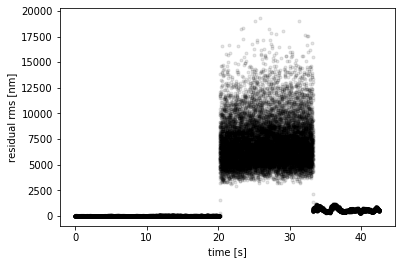

In [22]:
# Different data
testfile3 = "/g/lu/data/keck_telemetry/20170505/sdata904/nirc15/2017may05/n0130_LGS_trs.sav"
data = readsav(testfile3)
res = data.a.residualrms[0][0]
#x = np.linspace(0, len(res)/100, len(res))
x = data.a.timestamp[0]/1e7 # seconds
x -= x[0]
plt.plot(x, res, 'k.', alpha = 0.1, linewidth = 0.5)
plt.xlabel('time [s]')
plt.ylabel('residual rms [nm]')
plt.savefig(p_util.plot_dir+"telemetry_20170505_high_resid_rms.png")

#### Weather correlation plot

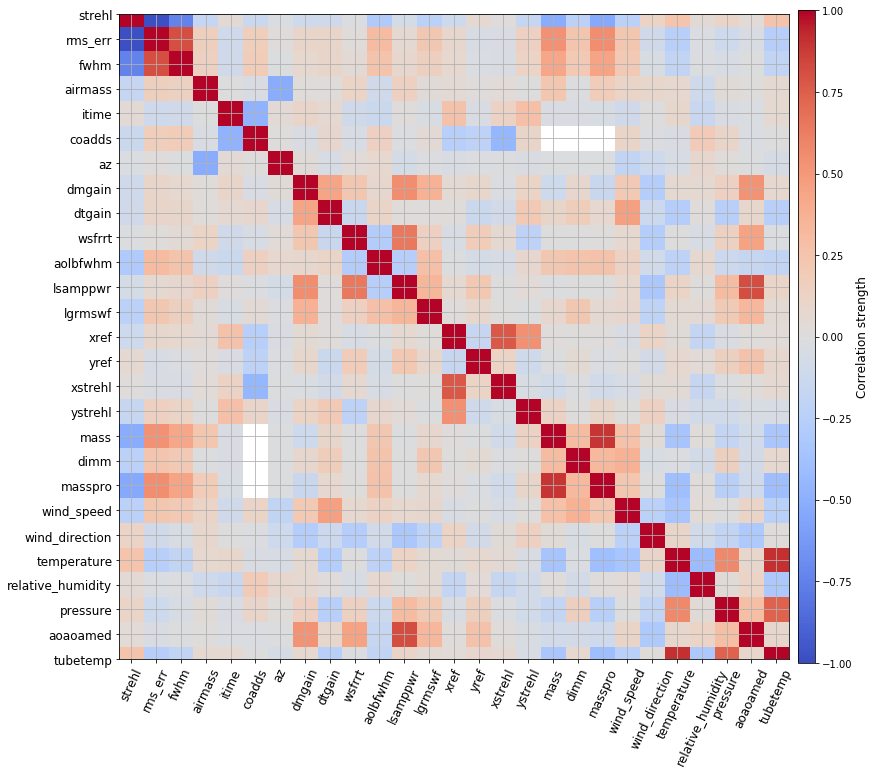

In [23]:
### Plot covariance and correlation plots from Steve's paper
p_util.setup("Results", 'weather')

labels = ["strehl", "rms_err", "fwhm", "airmass", "itime", "coadds", "az", "dmgain", "dtgain", "wsfrrt",
          "aolbfwhm", "lsamppwr", "lgrmswf", "xref", "yref", "xstrehl", "ystrehl", "mass", "dimm",
          "masspro", "wind_speed", "wind_direction", "temperature", "relative_humidity", "pressure",
          "aoaoamed", "tubetemp"]
p_util.correlation_matrix(my_data, labels=labels, figsize=(12, 12), save=True, filename="weather_corr.png")

In [24]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/plot_util.py'>

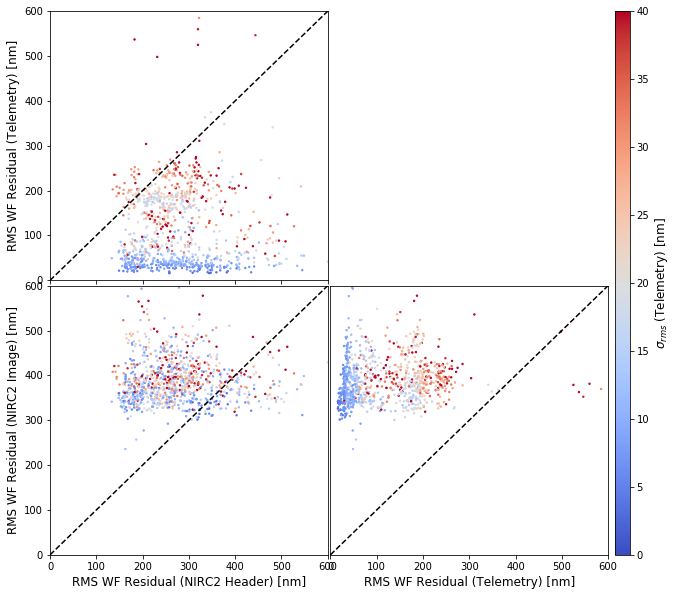

In [25]:
p_util.setup("Results", 'combined')
settings = p_util.default_settings.copy()
settings['label']['lgrmswf'] = 'RMS WF Residual (NIRC2 Header) [nm]'
labels = ['lgrmswf', 'residual_rms', 'rms_err']
p_util.plot_vars(df3, labels, settings=settings, figsize=(10,10), c_var='residual_rms_std', fmt='corner', 
                 cmap='coolwarm', diag=True, save=True)

#### FWHM and Strehl plotted over time

In [26]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/plot_util.py'>

In [27]:
### Sort data
data = my_data
labels = ['strehl', 'fwhm', 'aolbfwhm']
mj_days = np.unique(data.mjd.astype('int'))

# Separate data by day
data_by_day = {label:[
        data[label][data.mjd.astype(int)==day] 
        for day in mj_days
    ] for label in labels
}

means = {
    label: [np.mean(day) for day in days]
    for label, days in data_by_day.items()
}
medians = {
    label: [np.median(day) for day in days]
    for label, days in data_by_day.items()
}
std_devs = {
    label: [np.std(day)/np.sqrt(len(day)) for day in days]
    for label, days in data_by_day.items()
}
dec_year = Time(mj_days, format='mjd').decimalyear

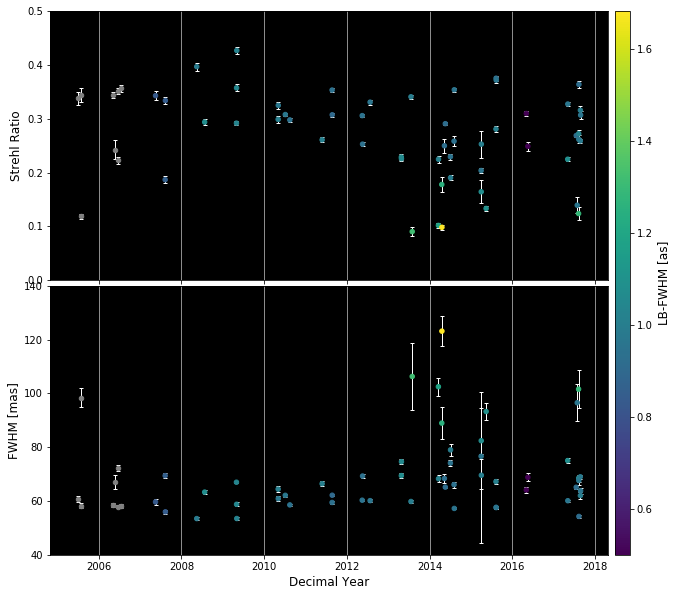

In [29]:
p_util.setup("Methods", 'weather')

box_plot = pd.DataFrame()
box_plot['dec_year'] = dec_year
box_plot['strehl'] = medians['strehl']
box_plot['fwhm'] = medians['fwhm']
box_plot['strehl_err'] = std_devs['strehl']
box_plot['fwhm_err'] = std_devs['fwhm']
box_plot['aolbfwhm'] = means['aolbfwhm']

p_util.plot_vars(box_plot, x_vars=['dec_year'], y_vars=['strehl','fwhm'], y_err=['strehl_err', 'fwhm_err'],
                 c_var='aolbfwhm', fmt='box', figsize=(10,10), save=True, filename='img_quality_vs_time.png')